In [1]:
# Import
import sys
sys.path.append("../src")
from scipy import signal
import scipy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from common import (
    load_config,
    setup_or_load_project, 
    iterate_experiments,
    create_folders,
    def_folders,
    load_conv_results,
    iterate_experiments_filt)
from response_detector import (
    stim_sum_flexible)
from response_tabel_creator import (
    stim_avg_flexible_1d,
    save_stim_to_csv,
    log_stim_quality,
    )
from signal_converter import (
    load_mask)
from visualisation import (
    process_signal,
    summarize_stim_dict_by_type,
    average_stimulus_from_dict,
    save_single_roi_as_bmp,
    apply_mask_and_average,
    average_stim_repeats,
    get_avg_and_error,
    plot_single_panel_signals)

In [2]:
# Change the path here
config_path = r'D:\Analysis_test\config.yaml'
config_stim_path = r'D:\Analysis_test\config_stim.yaml'
res_dir, info_dir, demonstr_dir, result_directory_stim, result_directory_masks = setup_or_load_project(
    config_path=config_path,
    create_func=create_folders,
    def_func=def_folders
)

config = load_config(config_path)
stim_config = load_config(config_stim_path)

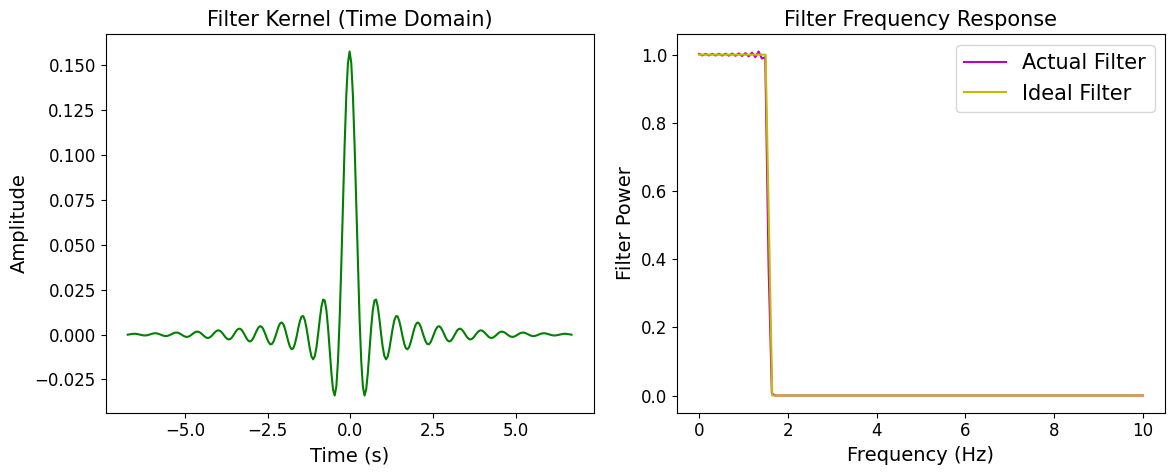

In [3]:
# Create filter kernel for frequency-based filtering (low-pass)
sampling_rate = 20  # Hz
cutoff_freq = 1.5   # Hz
transition_width = 0.1
filter_order = int(np.round(20 * sampling_rate / cutoff_freq)) + 1

# Ensure filter order is odd
if filter_order % 2 == 0:
    filter_order += 1

# Define desired frequency response shape
desired_shape = [1, 1, 0, 0]
frequency_points = [
    0,
    cutoff_freq,
    cutoff_freq + cutoff_freq * transition_width,
    sampling_rate / 2
]

# Design filter kernel using least-squares method
filter_kernel = signal.firls(
    filter_order,
    frequency_points,
    desired_shape,
    fs=sampling_rate
)

# Compute power spectrum of the filter (frequency response)
filter_power = np.abs(scipy.fftpack.fft(filter_kernel)) ** 2
hz = np.linspace(0, sampling_rate / 2, int(np.floor(len(filter_kernel) / 2) + 1))
filter_power = filter_power[:len(hz)]

# Plot the filter kernel and frequency response
plt.figure(figsize=(12, 5))

# Plot the filter kernel (time domain)
plt.subplot(121)
plt.plot(np.arange(-filter_order / 2, filter_order / 2) / sampling_rate, filter_kernel, color='g')
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.title('Filter Kernel (Time Domain)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot the frequency response
plt.subplot(122)
plt.plot(hz, filter_power, 'm', label='Actual Filter')
plt.plot(np.array(frequency_points), desired_shape, 'y', label='Ideal Filter')
plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('Filter Power', fontsize=14)
plt.title('Filter Frequency Response', fontsize=15)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [4]:
# --- Generate list of experiments based on filter criteria ---
experiment_list = list(iterate_experiments_filt(
    config["all_exp_dir"],
    mice_to_include=config.get("mice_to_include"),
    protocols_to_include=config.get("protocols_to_include"),
    state_to_include=config.get("state_to_include"),
    exp_to_include=config.get("exp_to_include"))
)

# --- Loop through experiments ---
for i, (img_dir, exp, mouse, state, protocol) in enumerate(experiment_list):
    print(f"[{i}] {mouse}_{exp}_{protocol}_{state}")

    # --- Load data ---
    filename = f'{mouse}_{exp}_{protocol}_{state}_conv'
    Ca_corr, dcHBO, dcHBR, dcHBT, Ca_wocorr = load_conv_results(
        save_path=res_dir / "Conv_signal",
        filename=filename,
        save_format=config['save_format'],
        return_wocorr=True
    )

    # --- Load full mask ---
    mask = load_mask(res_dir, mouse, exp, protocol, state, config)

    # --- Load ROI mask ---
    # Ensure the mask is binary (0 and 255)
    mask_path = res_dir / 'ResponseMasks_Drawn' / f"{mouse}_{exp}_{protocol}_Awake_roi.bmp"
    roi_mask = np.array(Image.open(mask_path)) > 0  # Binarize if needed

    # Check mask shape
    print(f"ROI mask shape: {roi_mask.shape}")  # (H, W)

    # --- Compute average signals within the ROI ---
    signal_ca_corr   = apply_mask_and_average(Ca_corr, roi_mask)
    signal_ca_wocorr = apply_mask_and_average(Ca_wocorr, roi_mask)
    signal_dhbo      = apply_mask_and_average(dcHBO, roi_mask)
    signal_dhbr      = apply_mask_and_average(dcHBR, roi_mask)
    signal_dhbt      = apply_mask_and_average(dcHBT, roi_mask)

    # --- Apply low-pass filtering to Hb signals ---
    signal_dhbt = signal.filtfilt(filter_kernel, 1, signal_dhbt, axis=0)
    signal_dhbo = signal.filtfilt(filter_kernel, 1, signal_dhbo, axis=0)
    signal_dhbr = signal.filtfilt(filter_kernel, 1, signal_dhbr, axis=0)

    # --- Stimulus metadata ---
    stim_type = protocol.split('-')[0]
    stim_cfg = stim_config['stim_1d']

    # --- Save stimulus-averaged traces for each signal ---
    process_signal(signal_ca_corr, "Ca", result_directory_stim, mouse, protocol, exp, state, stim_type, stim_cfg)
    process_signal(signal_ca_wocorr, "Cawocorr", result_directory_stim, mouse, protocol, exp, state, stim_type, stim_cfg)
    process_signal(signal_dhbt, "dcHbT", result_directory_stim, mouse, protocol, exp, state, stim_type, stim_cfg)
    process_signal(signal_dhbo, "dcHbO", result_directory_stim, mouse, protocol, exp, state, stim_type, stim_cfg)
    process_signal(signal_dhbr, "dcHbR", result_directory_stim, mouse, protocol, exp, state, stim_type, stim_cfg)

    # --- Print final signal shape ---
    print(f"Ca_corr (ROI averaged) shape: {signal_ca_corr.shape}")  # (T,)

Processing experiment day: Example
Found: exp=Example, mouse=m4433, state=Awake, protocol=RV-pulse09
Found: exp=Example, mouse=m8j, state=Awake, protocol=RHL-90mkA
[0] m4433_Example_RV-pulse09_Awake
ROI mask shape: (64, 87)
Ca_corr (ROI averaged) shape: (8800,)
[1] m8j_Example_RHL-90mkA_Awake
ROI mask shape: (64, 87)
Ca_corr (ROI averaged) shape: (8800,)
